In [711]:
# Library imports
import twint
import nest_asyncio

nest_asyncio.apply()
import pandas as pd
from datetime import datetime, timedelta

import os
import pathlib
import time
import json


In [712]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

sns.set_style('whitegrid')
np.random.seed(42)

In [713]:
pd.set_option('display.max_colwidth', 0)

In [714]:
from datetime import date, datetime, timedelta

def date_range(start_date, end_date):
    delta = end_date - start_date  # as timedelta
    days = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(delta.days + 1)]
    return days # YYYY-MM-DD

start_date = date(2022, 1, 1)
end_date = date(2022, 3, 5)

year = start_date.year


In [715]:
date_list = date_range(start_date, end_date)

In [716]:
date_list[-1]

'2022-03-05'

# Twint

In [717]:
def getTweets(search_term, since, until, limit):

    df_list = []

    """
    Configures Twint and returns a dataframe of tweets for a specific day.
    """
    # Configuring Twint for search
    c = twint.Config()

    # The limit of tweets to retrieve
    c.Limit = limit

    # Search term
    c.Search = search_term

    # Removing retweets
    c.Filter_retweets = True

    # Popular tweets
    c.Popular_tweets = True

    # Lowercasing tweets
    c.Lowercase = True

    # English only
    c.Lang = "en"

    c.Min_retweets = 5
    c.Since = since + " 00:00:00"

    # Tweets until a specified date
    c.Until = until + " 00:00:00"

    # Making the results pandas friendly
    c.Pandas = True

    # Stopping print in terminal
    c.Hide_output = True

    # Searching
    twint.run.Search(c)

    # Assigning the DF
    df = twint.storage.panda.Tweets_df

    # Returning an empty DF if no tweets were found
    if len(df) <= 0:
        return df_list

    # Formatting the date
    df["date"] = df["date"].apply(lambda x: x.split(" ")[0])

    df_list.append(df)

    return df_list

In [718]:
# ticker = "AAPL,MSFT,AMZN,FB,GOOG,GOOGL,TSLA,NVDA,PYPL,ASML,INTC,CMCSA,NFLX,ADBE,CSCO,PEP,AVGO,TXN,TMUS"
ticker = ["$AAPL"]
idx = 0
df_list = getTweets(ticker[idx], "2010-01-04", "2010-01-05", 1000)

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.


In [719]:
len(df_list)

0

In [720]:
if len(df_list) > 0:
    df_list[0].head()

In [721]:
MAX_RETRIES = 5
list_of_dataframes = []
for s in date_list:
    e = (datetime.strptime(s, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    sleep_time_in_seconds = 0
    for i in range(MAX_RETRIES):
        sleep_time_in_seconds += 1
        time.sleep(sleep_time_in_seconds) # sleep from 1 to 5 seconds
        _df = getTweets(ticker[idx], s, e, 200)
        print(len(_df))
        if len(_df) == 0:
            continue
        else:
            list_of_dataframes.append(_df[0])
            break
        

    

[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
0
[!] No more data! Scraping will stop now.
found 0 deleted tweets in this search.
1
[!] 

In [722]:
len(list_of_dataframes)

62

In [723]:
df = pd.concat(list_of_dataframes)


In [724]:
df.shape

(1175, 38)

In [725]:
df.set_index("id", inplace=True)

In [726]:
df.index.is_unique

True

In [727]:
df[df.index.duplicated(keep=False)].sort_index().head()

,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [728]:
df = df[~df.index.duplicated(keep="first")]

In [729]:
df.shape

(1175, 37)

In [730]:
df_aapl_groupedby_date = df.groupby('date').count()
df_aapl_groupedby_date.reset_index(inplace=True)
df_aapl_groupedby_date.set_index("date", inplace=True)
df_aapl_groupedby_date = df_aapl_groupedby_date[["search"]]

In [731]:
df_aapl_groupedby_date.describe()

,search
count,62.000000
mean,18.951613
std,8.145053
min,6.000000
25%,14.000000
50%,18.000000
75%,20.000000
max,41.000000


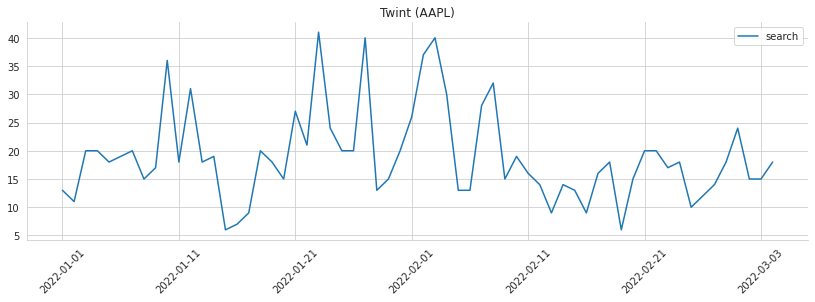

In [732]:
ax = df_aapl_groupedby_date["search"].plot(title='Twint (AAPL)',
           legend=True,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
sns.despine()

In [733]:
df.head()

,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,user_id,user_id_str,username,name,day,hour,link,urls,photos,video,thumbnail,retweet,nlikes,nreplies,nretweets,quote_url,search,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1477425772046401537,1477425772046401537,1.641081e+12,2022-01-01,+0000,,"Stocks cannot go up long on pump-and-dumps and financial fingering ( $PLTR $NIO $NKLA) Only 2 ways stocks can go up : 1. They are making exceptional profits per share ( $MSFT , $FB, , $AAPL, $UHAL) 2. Or they are expected to make exceptional profit per share ( $TSLA, $AMD )",en,[],"[pltr, nio, nkla, msft, fb, aapl, uhal, tsla, amd]",345525945,345525945,TicTocTick,emini tic,6,23,https://twitter.com/TicTocTick/status/1477425772046401537,[],[],0,,False,342,18,41,,$AAPL,,,,,,,[],,,,
1477423930805833728,1477423930805833728,1.641080e+12,2022-01-01,+0000,,"Opening up my discord to the public! Live private alerts, Charts, Education, Watchlists, Risk Management, and most importantly how to master $TSLA $AAPL &amp; $SPY https://t.co/WyQyh5SpY6",en,[],"[tsla, aapl, spy]",1182097655687733248,1182097655687733248,KorabiTrades,Korabi,6,23,https://twitter.com/KorabiTrades/status/1477423930805833728,[https://discord.gg/3CVJ4gSn],[],0,,False,28,1,5,,$AAPL,,,,,,,[],,,,
1477409531831283712,1477409531831283712,1.641077e+12,2022-01-01,+0000,,"2022 I will only trade large cap companies so everyone can finally shut the fuck up, I’m gonna make their and their families lifetime salary this year just trading $SPY $AMD $NVDA $AAPL $TSLA and so on, I promise you that. Coming back to this tweet in a week for weekly update",en,[],"[spy, amd, nvda, aapl, tsla]",1382530260793581570,1382530260793581570,STXRBOY999,T2G x MMA🌟,6,22,https://twitter.com/STXRBOY999/status/1477409531831283712,[],[],0,,False,686,86,27,,$AAPL,,,,,,,[],,,,
1477404718842499076,1477404718842499076,1.641076e+12,2022-01-01,+0000,,*Pretty solid overall performance from my 2021 stock picks 1. $AAPL +33.8% 2. $AMZN +2.4% 3. $SHOP +21.7% 4. $CRWD -3.3% 5. $NET +73% 6. $ROKU -31.2% 7. $TTD +14.4% 8. $DOCU -31.4% 9. $OKTA -11.8% 10. $MDB +40.4% 11. $DDOG +80.9% ⚠️My 2022 picks will be out Sunday,en,[],"[aapl, amzn, shop, crwd, net, roku, ttd, docu, okta, mdb, ddog]",19534637,19534637,JesseCohenInv,Jesse Cohen,6,22,https://twitter.com/JesseCohenInv/status/1477404718842499076,[],[],0,,False,520,32,57,https://twitter.com/JesseCohenInv/status/1345864211151417345,$AAPL,,,,,,,[],,,,
1477404571680972801,1477404571680972801,1.641076e+12,2022-01-01,+0000,,1/3 Top 3 $PENN $53C &gt; $52.45 | $51P &lt; $51.20 $UBER $44C &gt; $42.40 | $40P &lt; $41.65 $AAPL $180C &gt; $178.45 | $175P &lt; $176.65 Flow: @unusual_whales Breakdowns below,en,[],"[penn, uber, aapl]",1104877420421607425,1104877420421607425,channingtradeum,Channing Tradeum,6,22,https://twitter.com/channingtradeum/status/1477404571680972801,[],[],0,,False,109,7,15,,$AAPL,,,,,,,[],,,,


In [734]:
ticker_cleaned = ticker[idx].replace("$", "")
path = pathlib.Path.cwd() / f'{ticker_cleaned}_twint_{year}.csv'

df.to_csv(path)

In [735]:
print(path)

/app/StockPricePredictions/src/exploratory_data_analysis/chance/python/samples/twint/AAPL_twint_2022.csv


In [736]:
df_x = pd.read_csv(path, lineterminator='\n')

In [737]:
df_x.shape

(1175, 38)